# EQUITY AMERICAN OPTION - BJERKSUND STENSLAND APPROXIMATION

Valuation and Risk of American-style options on equity using BJERKSUND STENSLAND approximation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.market.curves.discount_curve_flat import *
from financepy.products.equity import *
from financepy.models.black_scholes import *

####################################################################
# FINANCEPY BETA Version 0.270 - This build:  13 Feb 2023 at 17:38 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# Define the American Call and Put Options

In [3]:
valuation_date = Date(8, 5, 2015)

In [4]:
expiry_date = Date(7, 5, 2018)

In [5]:
strike_price = 100

## Create the call Option

In [6]:
amCallOption = EquityAmericanOption(expiry_date, strike_price, OptionTypes.AMERICAN_CALL)
amCallOption

OBJECT TYPE: EquityAmericanOption
EXPIRY DATE: 07-MAY-2018
STRIKE PRICE: 100
OPTION TYPE: OptionTypes.AMERICAN_CALL
NUMBER: 1.0

We also define an actual vanilla call option which will be priced using Black Scholes.

In [7]:
euCallOption = EquityAmericanOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)
euCallOption 

OBJECT TYPE: EquityAmericanOption
EXPIRY DATE: 07-MAY-2018
STRIKE PRICE: 100
OPTION TYPE: OptionTypes.EUROPEAN_CALL
NUMBER: 1.0

## Create the put Option

In [8]:
amPutOption = EquityAmericanOption(expiry_date, strike_price, OptionTypes.AMERICAN_PUT)
amPutOption

OBJECT TYPE: EquityAmericanOption
EXPIRY DATE: 07-MAY-2018
STRIKE PRICE: 100
OPTION TYPE: OptionTypes.AMERICAN_PUT
NUMBER: 1.0

In [9]:
euPutOption = EquityAmericanOption(expiry_date, strike_price, OptionTypes.EUROPEAN_PUT)
euPutOption

OBJECT TYPE: EquityAmericanOption
EXPIRY DATE: 07-MAY-2018
STRIKE PRICE: 100
OPTION TYPE: OptionTypes.EUROPEAN_PUT
NUMBER: 1.0

Now we can explore the pricing of all three to check for consistency and tree convergence.

# Valuation
For the validatoin of Bjerksund Stensland annalytical approximation model,  same parameters are used as thier paper - see Table 4 in https://www.sciencedirect.com/science/article/abs/pii/095652219390009H

In [10]:
volatility = 0.20
interest_rate =  0.08
dividend_yield = 0.04
discount_curve = DiscountCurveFlat(valuation_date, interest_rate,
                                     FrequencyTypes.CONTINUOUS, 
                                     DayCountTypes.ACT_365F)
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield,
                                   FrequencyTypes.CONTINUOUS, 
                                   DayCountTypes.ACT_365F)

We now define the model. This is Black-Scholes. We can also specify the number of steps to use on the tree.

As disccussed in [Tree Convergence](#tree), 200 steps are egnough.

In [11]:
num_steps_per_year = 200

In [12]:
modelTree = BlackScholes(volatility, BlackScholesTypes.CRR_TREE, num_steps_per_year)
modelBAApprox = BlackScholes(volatility, BlackScholesTypes.BARONE_ADESI)
modelBSApprox = BlackScholes(volatility, BlackScholesTypes.Bjerksund_Stensland)
modelAnal = BlackScholes(volatility, BlackScholesTypes.ANALYTICAL)

## Valuation of Call Option

In [13]:
amTreeValue  = []
amBAWValue = []
amBJSValue = []
euBSValue = []
euTreeValue = []
stock_price_lists = np.linspace(80, 200, 13)
for stock_price in stock_price_lists:
    amTreeValue.append(amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree))
    amBAWValue.append(amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelBAApprox))
    amBJSValue.append(amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelBSApprox))
    euBSValue.append(euCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelAnal))
    euTreeValue.append(euCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree))

First, we validate Bjerksund Stensland approximation model by data available from thier paper - see Table 4 in https://www.sciencedirect.com/science/article/abs/pii/095652219390009H

In [14]:
validation_data = [6.88, 11.48, 17.20, 23.82, 31.12]
for i in range(5):
    print(f"stock price:{stock_price_lists[i]:8.2f}, value:{round(amBJSValue[i],2):8.2f}, validation_data:{validation_data[i]:8.2f}")

stock price:   80.00, value:    6.88, validation_data:    6.88
stock price:   90.00, value:   11.49, validation_data:   11.48
stock price:  100.00, value:   17.20, validation_data:   17.20
stock price:  110.00, value:   23.82, validation_data:   23.82
stock price:  120.00, value:   31.13, validation_data:   31.12


The values are close to their results, thus this new model is implemented correctly.

Next,  we compare each American option pricing model.

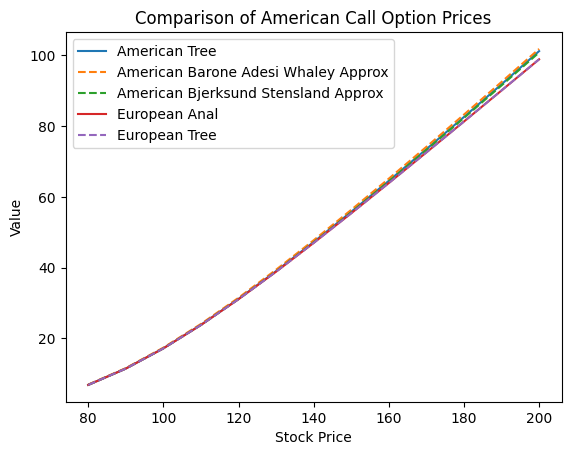

In [15]:
plt.title("Comparison of American Call Option Prices")
plt.plot(stock_price_lists, amTreeValue, label="American Tree")
plt.plot(stock_price_lists, amBAWValue, label="American Barone Adesi Whaley Approx", linestyle="dashed")
plt.plot(stock_price_lists, amBJSValue, label="American Bjerksund Stensland Approx", linestyle="dashed")
plt.plot(stock_price_lists, euBSValue, label="European Anal")
plt.plot(stock_price_lists, euTreeValue, label="European Tree", linestyle="dashed")
plt.xlabel("Stock Price")
plt.ylabel("Value")
plt.legend();

By the above figure, you can see:
- Two analytical appoximations are close to binomial tree model.
- European value is lower as we would expect due to the lack of early exercise.

## Valuation of Put Option

In [16]:
amTreeValue  = []
amBAWValue = []
amBSValue = []
euBSValue = []
euTreeValue = []
stock_price_lists = np.linspace(80, 200, 16)
for stock_price in stock_price_lists:
    amTreeValue.append(amPutOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree))
    amBAWValue.append(amPutOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelBAApprox))
    amBSValue.append(amPutOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelBSApprox))
    euBSValue.append(euPutOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelAnal))
    euTreeValue.append(euPutOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree))

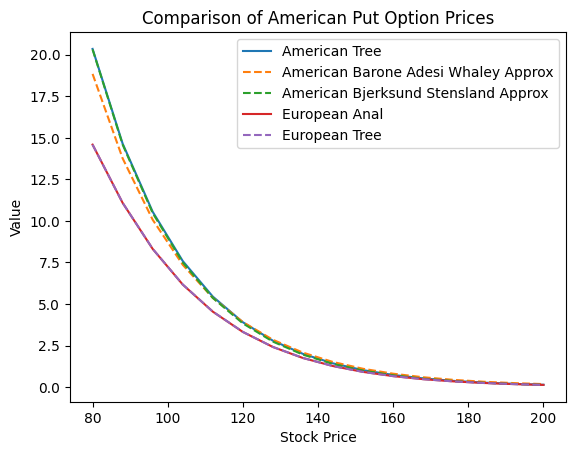

In [17]:
plt.title("Comparison of American Put Option Prices")
plt.plot(stock_price_lists, amTreeValue, label="American Tree")
plt.plot(stock_price_lists, amBAWValue, label="American Barone Adesi Whaley Approx", linestyle="dashed")
plt.plot(stock_price_lists, amBSValue, label="American Bjerksund Stensland Approx", linestyle="dashed")
plt.plot(stock_price_lists, euBSValue, label="European Anal")
plt.plot(stock_price_lists, euTreeValue, label="European Tree",linestyle="dashed")
plt.xlabel("Stock Price")
plt.ylabel("Value")
plt.legend();

Same argument as call option's case.
- By comparing three American option values, you can see that two analytical appoximations are close to binomial tree model.
- European value is lower as we would expect due to the lack of early exercise.

## Tree Convergence
<a id='tree'></a>

In [18]:
num_steps_per_year = range(5, 200, 1)

In [19]:
amTreeValue = []
amBAWValue = []
amBJSValue = []
euTreeValue = []
euAnalValue = []
stock_price = 200.0
for num_steps in num_steps_per_year:

    modelTree = BlackScholes(volatility,
                                     BlackScholesTypes.CRR_TREE,
                                     num_steps)

    modelAnal = BlackScholes(volatility, 
                                     BlackScholesTypes.ANALYTICAL)

    modelBAW = BlackScholes(volatility, 
                                    BlackScholesTypes.BARONE_ADESI)
    modelBJS = BlackScholes(volatility, 
                                    BlackScholesTypes.Bjerksund_Stensland)
    
    v_am = amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree)
    v_eu = euCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree)
    v_bs = euCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelAnal)
    v_am_baw = amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelBAW)
    v_am_bjs = amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelBJS)
    amTreeValue.append(v_am)
    euTreeValue.append(v_eu)
    euAnalValue.append(v_bs)
    amBAWValue.append(v_am_baw)
    amBJSValue.append(v_am_bjs)

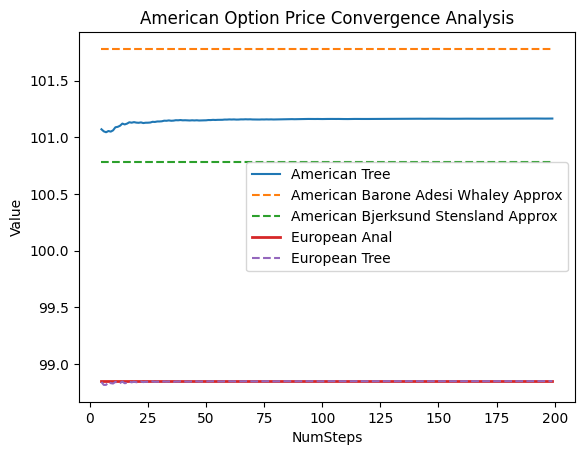

In [20]:
plt.title("American Option Price Convergence Analysis")
plt.plot(num_steps_per_year, amTreeValue, label="American Tree")
plt.plot(num_steps_per_year, amBAWValue, label="American Barone Adesi Whaley Approx", linestyle="dashed")
plt.plot(num_steps_per_year, amBJSValue, label="American Bjerksund Stensland Approx", linestyle="dashed")
plt.plot(num_steps_per_year, euAnalValue, label="European Anal", lw =2)
plt.plot(num_steps_per_year, euTreeValue, label="European Tree", linestyle="dashed")
plt.xlabel("NumSteps")
plt.ylabel("Value")
plt.legend();

 We see that convergence is already achieved at the 100th step, which is sufficient for the accuracy of the tree model.

Copyright (c) 2020 Dominic O'Kane